## Set to directory with python scripts

In [1]:
scripts_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts/'
path_to_save = '/'.join(scripts_path.split('/')[:-2]) + '/'
save_path = '/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/'
%cd $scripts_path

/Users/jendawk/Dropbox (MIT)/C Diff Recurrence Paper/Analyses/scripts


## Load modules

In [2]:
import scipy.stats as st
from collections import Counter
import sklearn
from matplotlib import cm
import scipy
import  itertools
from datetime import datetime
from seaborn import clustermap
from scipy.cluster.hierarchy import linkage
from sklearn.linear_model import LogisticRegression
import os
import time
import pickle as pkl
import pandas as pd
from dataLoader import *
from basic_data_methods_helper import *
from skbio.stats.distance import permanova, DistanceMatrix, anosim
from skbio.stats.distance import mantel
from statsmodels.stats.multitest import multipletests
from matplotlib.collections import LineCollection
from Bio import Phylo
import re
from statistics import mode
import seaborn as sns
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.lines as mlines
import seaborn as sns
from skbio.diversity.alpha import chao1

# Set font for figures
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

## Load data

In [3]:
# set data_path to point to directory with data
data_path = save_path + "Data/"

# Option to change filtering criteria
dl = dataLoader(path = data_path, pt_perc = {'metabs': .25, '16s': .1, 'scfa': 0, 'toxin':0}, meas_thresh = 
                {'metabs': 0, '16s': 10, 'scfa': 0, 'toxin':0}, 
                var_perc = {'metabs': 50, '16s': 5, 'scfa': 0, 'toxin':0}, pt_tmpts = 1)

/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Fig 2 - Entropy 

### Calculate entropy

In [13]:
entropy_df = {i: pd.DataFrame({'Week ' + str(i): [chao1(dl.week_raw['16s'][i]['x'].loc[k,:]) 
                                                  for k in dl.week_raw['16s'][i]['x'].index.values], 
                               'Outcome': dl.week_raw['16s'][i]['y']}) 
              for i in dl.week_raw['16s'].keys()}
bins = [i for i in entropy_df.keys() if isinstance(i, int)]

entropy_f = {}
for b in bins:
    
    b1 = entropy_df[b]
    if b +.5 not in entropy_df.keys():
        entropy_f[b] = entropy_df[b]
        continue
    b2 = entropy_df[b + .5]
    ix_sim = list(set(b1.index.values).intersection(set(b2.index.values)))
    ix_all = np.concatenate((b1.index.values,b2.index.values))
    df = pd.DataFrame(index = np.unique(ix_all), columns = ['Week ' + str(b), 'Outcome'])
    df['Outcome'][b1.index.values] = b1['Outcome']
    df['Outcome'][b2.index.values] = b2['Outcome']
    
    df['Week '+ str(b)][b1.index.values] = b1['Week ' + str(b)]
    df['Week '+ str(b)][b2.index.values] = b2['Week ' + str(b+0.5)]
    
    b_together = (b1['Week ' + str(b)][ix_sim] + b2['Week ' + str(b+0.5)][ix_sim])/2
    df['Week '+ str(b)][ix_sim] = b_together
    
    entropy_f[b] = df

### Save entropy data

In [14]:
path_to_save_data=save_path + '/GenFigure&AnalysesData/'
if not os.path.isdir(path_to_save_data):
    os.mkdir(path_to_save_data)
    
for key in entropy_df.keys():
    if os.path.isfile(path_to_save_data + '/' + 'Fig2_entropy_data.xlsx'):
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig2_entropy_data.xlsx', mode='a') as writer:
            pd.DataFrame(entropy_df[key]).to_excel(writer, sheet_name='Week ' + str(key))
    else:
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig2_entropy_data.xlsx', mode = 'w') as writer:
            pd.DataFrame(entropy_df[key]).to_excel(writer, sheet_name = 'Week ' + str(key))


### Plot entropy and run inter-group entropy and intra-group entropy statistical tests

font: 11.000000000000002
axes_title: 12.0
axes_label: 12.0
xtick_label: 12.0
ytick_label: 10.0
legend: 11.000000000000002
figure_title: 12.0


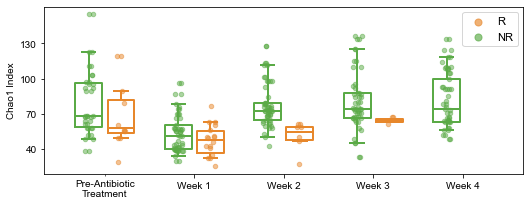

In [15]:
path_to_save_data = save_path + 'Supplemental Tables/'
if not os.path.isdir(path_to_save_data):
    os.mkdir(path_to_save_data)
    
fig, ax_entropy = plt.subplots(figsize=(7.5,3))

set_font_sizes(None, {'font': 11, 'axes_title': 12, 'axes_label': 12, 
                                          'xtick_label': 12, 'ytick_label': 10, 
                         'legend': 11, 'figure_title': 12})

out_dict = {}
tmpt_dict = {}
# PCA
fig, ax_entropy = plot_entropy_boxplots(entropy_f, fig, ax_entropy, 
                                        fig_title = None, 
                                        week_colors = {'Recurrer':'#E7872B','Non-recurrer':'#5AAA46'})
ent_over_time = entropy_over_time(entropy_f)
ent_over_time.index = ['Week 0 to 1','Week 1 to 2']
with pd.ExcelWriter(path_to_save_data + 'Table 1. Entropy & Dissimilarity.xlsx', mode='w') as writer:
    pd.DataFrame(ent_over_time).to_excel(writer, sheet_name='A. Entropy, Intra-Group')
            

ent_bw_grps = entropy_bw_grps(entropy_f)
ent_bw_grps.index = ['Week 0', 'Week 1', 'Week 2']
with pd.ExcelWriter(path_to_save_data + 'Table 1. Entropy & Dissimilarity.xlsx', mode = 'a') as writer:
    pd.DataFrame(ent_bw_grps).to_excel(writer, sheet_name = 'B. Entropy, Inter-Group')

# ax_entropy.grid(axis='y', zorder = -1)
ax_entropy.set_yticks([40,70,100,130])
fig.tight_layout()

if not os.path.isdir(path_to_save +'output_figures'):
    os.mkdir(path_to_save +'output_figures')
plt.savefig(path_to_save + 'output_figures/Fig2_entropy.pdf')
plt.show()

# Supplemental figure 3 - Beta diversity & Spearman PCoA

## Plot with separating groups in intra-group analysis and timepoints in inter-group analysis

### Plot ASVs

font: 11.000000000000002
axes_title: 12.0
axes_label: 10.0
xtick_label: 10.0
ytick_label: 10.0
legend: 11.000000000000002
figure_title: 12.0
(112, 112)
(112, 112)
(112, 112)
(112, 112)
(112, 112)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


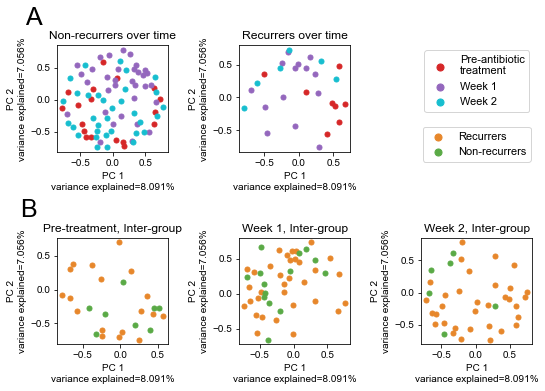

In [4]:
fig, ax = plt.subplots(2,3,figsize = (8.5,5.5))
ax_intra = ax[0,:-1]
ax_inter = ax[1,:]
ax[0,-1].set_visible(False)

out_dict = {}
tmpt_dict = {}
# PCA
set_font_sizes(None, {'font': 11, 'axes_title': 12, 'axes_label': 10, 
                                          'xtick_label': 10, 'ytick_label': 10, 
                         'legend': 11, 'figure_title': 12})

counts = pd.DataFrame(np.vstack([dl.week_raw['16s'][i]['x'] for i in [0,1,2]]), index = \
    np.concatenate([dl.week_raw['16s'][i]['x'].index.values for i in [0,1,2]]), \
                          columns = dl.week_raw['16s'][0]['x'].columns.values)
prop_y = np.concatenate([dl.week_raw['16s'][i]['y'] for i in [0,1,2]])
prop_y_tmpts = np.array([x.split('-')[1] for x in counts.index.values]).astype(float).astype(int).astype(str)
for ii,outcome in enumerate(['Non-recurrer','Recurrer']):
    keep_ix = prop_y == outcome
    dat = counts
    pca_dF, variances, d1 = pcoa_custom(dat, metric='braycurtis', metric_mds = True)
    pca_dF = pca_dF.iloc[keep_ix,:]
    fig, ax_intra[ii], l1,l2 = plot_PCA(pca_dF, variances, prop_y_tmpts[keep_ix], path=None, 
                          target_labels=None,
                           fig = fig, ax = ax_intra[ii], legend = False, x_label = 'PC 1\nvariance explained=',
                                   y_label = 'PC 2\nvariance explained=',
                                        colors = {0:'tab:red',1:'tab:purple',2:'tab:cyan'})
    ax_intra[ii].set_title(outcome + 's over time')
    
    
for ii,tmpt in enumerate([0,1,2]):
    keep_ix = prop_y_tmpts == str(tmpt)
    dat = counts
    pca_dF, variances, d1 = pcoa_custom(dat, metric='braycurtis', metric_mds = True)
    pca_dF = pca_dF.iloc[keep_ix,:]
    fig, ax_inter[ii], l1,l2 = plot_PCA(pca_dF, variances, prop_y[keep_ix], path=None, 
                          target_labels=None,colors = {'Recurrer':'#E7872B','Non-recurrer':'#5AAA46'},
                                      
                           fig = fig, ax = ax_inter[ii], legend = False, x_label = 'PC 1\nvariance explained=',
                                   y_label = 'PC 2\nvariance explained=')
    if ii == 0:
        ax_inter[ii].set_title('Pre-treatment, Inter-group')
    else:
        ax_inter[ii].set_title('Week ' + str(tmpt) + ', Inter-group')

re = ax_inter[-1].scatter([],[],c = '#E7872B', s = 50)
nre = ax_inter[-1].scatter([],[],c = '#5AAA46', s = 50)
fig.legend([re, nre], ['Recurrers', 'Non-recurrers'], loc = 'center', bbox_to_anchor=(.81, .63))

cmap = sns.color_palette("tab10", as_cmap = True)
zero = ax_inter[-1].scatter([],[],c = 'tab:red', s = 50)
one = ax_inter[-1].scatter([],[],c = 'tab:purple', s = 50)
two = ax_inter[-1].scatter([],[],c = 'tab:cyan', s = 50)
three = ax_inter[-1].scatter([],[],c = cmap(7), s = 50)
four = ax_inter[-1].scatter([],[],c = cmap(8), s = 50)
fig.legend([zero, one, two], ['Pre-antibiotic\ntreatment', 'Week 1', 'Week 2'], 
           loc = 'center', bbox_to_anchor=(.81, .79))

xy_e = get_panal_locs(ax[0,0])
ax[0,0].annotate('A', xy = (xy_e[0]-.5, xy_e[1] + 0.15), annotation_clip = False, fontsize =25)

xy_e = get_panal_locs(ax[1,0])
ax[1,0].annotate('B', xy = (xy_e[0]-.5, xy_e[1] + 0.15), annotation_clip = False, fontsize =25)

# fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.65, hspace=.8)
if not os.path.isdir(path_to_save + 'supplemental_figures'):
    os.mkdir(path_to_save + 'supplemental_figures')
fig.savefig(path_to_save + 'supplemental_figures/FigS1.pdf', bbox_inches = 'tight')

### Plot metabolites

font: 11.000000000000002
axes_title: 12.0
axes_label: 10.0
xtick_label: 10.0
ytick_label: 10.0
legend: 11.000000000000002
figure_title: 12.0
(114, 114)
(114, 114)
(114, 114)
(114, 114)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(114, 114)


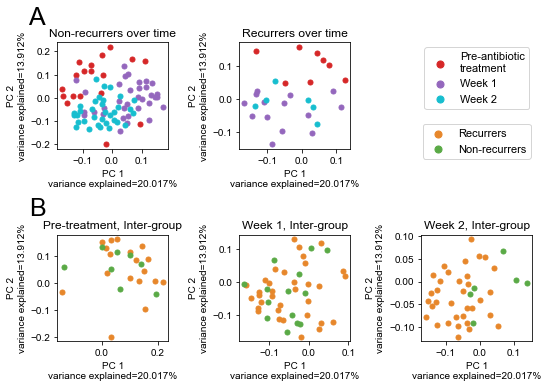

In [5]:
fig, ax = plt.subplots(2,3,figsize = (8.5,5.5))
ax_intra = ax[0,:-1]
ax_inter = ax[1,:]
ax[0,-1].set_visible(False)
out_dict = {}
tmpt_dict = {}
# PCA
set_font_sizes(None, {'font': 11, 'axes_title': 12, 'axes_label': 10, 
                                          'xtick_label': 10, 'ytick_label': 10, 
                         'legend': 11, 'figure_title': 12})

metabs = pd.DataFrame(np.vstack([dl.week_raw['metabs'][i]['x'] for i in [0,1,2]]), index = \
    np.concatenate([dl.week_raw['metabs'][i]['x'].index.values for i in [0,1,2]]), \
                      columns = dl.week_raw['metabs'][0]['x'].columns.values)
met_y = np.concatenate([dl.week_raw['metabs'][i]['y'] for i in [0,1,2]])
met_y_tmpts = np.array([x.split('-')[1] for x in metabs.index.values]).astype(float).astype(int).astype(str)
for ii,outcome in enumerate(['Non-recurrer','Recurrer']):
    keep_ix = met_y == outcome
    dat = metabs
    pca_dF, variances, d1 = pcoa_custom(dat, metric='spearman', metric_mds = True)
    pca_dF = pca_dF.iloc[keep_ix,:]
    fig, ax_intra[ii], l1,l2 = plot_PCA(pca_dF, variances, met_y_tmpts[keep_ix], path=None, 
                          target_labels=None,
                           fig = fig, ax = ax_intra[ii], legend = False, x_label = 'PC 1\nvariance explained=',
                                   y_label = 'PC 2\nvariance explained=',
                                       colors = {0:'tab:red',1:'tab:purple',2:'tab:cyan'})
    ax_intra[ii].set_title(outcome + 's over time')
    
    
for ii,tmpt in enumerate([0,1,2]):
    keep_ix = met_y_tmpts == str(tmpt)
    dat = metabs
    pca_dF, variances, d1 = pcoa_custom(dat, metric='spearman', metric_mds = True)
    pca_dF = pca_dF.iloc[keep_ix,:]
    fig, ax_inter[ii], l1,l2 = plot_PCA(pca_dF, variances, met_y[keep_ix], path=None, 
                          target_labels=None,colors = {'Recurrer':'#E7872B','Non-recurrer':'#5AAA46'},
                           fig = fig, ax = ax_inter[ii], legend = False, x_label = 'PC 1\nvariance explained=',
                                   y_label = 'PC 2\nvariance explained=')
    if ii == 0:
        ax_inter[ii].set_title('Pre-treatment, Inter-group')
    else:
        ax_inter[ii].set_title('Week ' + str(tmpt) + ', Inter-group')

re = ax_inter[-1].scatter([],[],c = '#E7872B', s = 50)
nre = ax_inter[-1].scatter([],[],c = '#5AAA46', s = 50)
fig.legend([re, nre], ['Recurrers', 'Non-recurrers'], loc = 'center', bbox_to_anchor=(.81, .63))

cmap = sns.color_palette("tab10", as_cmap = True)
zero = ax_inter[-1].scatter([],[],c = 'tab:red', s = 50)
one = ax_inter[-1].scatter([],[],c = 'tab:purple', s = 50)
two = ax_inter[-1].scatter([],[],c = 'tab:cyan', s = 50)
three = ax_inter[-1].scatter([],[],c = cmap(7), s = 50)
four = ax_inter[-1].scatter([],[],c = cmap(8), s = 50)
fig.legend([zero, one, two], ['Pre-antibiotic\ntreatment', 'Week 1', 'Week 2'], 
           loc = 'center', bbox_to_anchor=(.81, .79))

xy_e = get_panal_locs(ax[0,0])
ax[0,0].annotate('A', xy = (xy_e[0]-.1, xy_e[1] + 0.03), annotation_clip = False, fontsize =25)

xy_e = get_panal_locs(ax[1,0])
ax[1,0].annotate('B', xy = (xy_e[0]-.1, xy_e[1] + 0.03), annotation_clip = False, fontsize =25)
# fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.65, hspace=.8)
if not os.path.isdir(path_to_save + 'supplemental_figures'):
    os.mkdir(path_to_save + 'supplemental_figures')
fig.savefig(path_to_save + 'supplemental_figures/figS2.pdf', bbox_inches = 'tight')

## Run PERMANOVA statistical tests on metabolites and ASVs & save data

In [6]:
path_to_save_data=save_path + '/GenFigure&AnalysesData/'
np.random.seed(0)

metabs = pd.DataFrame(np.vstack([dl.week_raw['metabs'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl.week_raw['metabs'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                      columns = dl.week_raw['metabs'][0]['x'].columns.values)
met_y = np.concatenate([dl.week_raw['metabs'][i]['y'] for i in [0,1,2,3,4]])
met_y_tmpts = np.array([x.split('-')[1] for x in metabs.index.values]).astype(float).astype(int).astype(str)
pca_dF_met, variances, d1 = pcoa_custom(metabs, metric='spearman', metric_mds = True)
pca_dF_met.index = metabs.index.values

counts = pd.DataFrame(np.vstack([dl.week_raw['16s'][i]['x'] for i in [0,1,2,3,4]]), index = \
    np.concatenate([dl.week_raw['16s'][i]['x'].index.values for i in [0,1,2,3,4]]), \
                          columns = dl.week_raw['16s'][0]['x'].columns.values)
prop_y = np.concatenate([dl.week_raw['16s'][i]['y'] for i in [0,1,2,3,4]])
prop_y_tmpts = np.array([x.split('-')[1] for x in counts.index.values]).astype(float).astype(int).astype(str)
pca_dF_otus, variances, d_otus = pcoa_custom(counts, metric='braycurtis', metric_mds = True)
pca_dF_met.otus = counts.index.values
    

save_data = {'MetSpearDistMat': pd.DataFrame(d1, index = metabs.index.values, columns = metabs.index.values), 
             'ASV_BC_DistMat': pd.DataFrame(d_otus, index = counts.index.values, columns = counts.index.values), 
             'MetSpearPCoA': pca_dF_met, 
             'ASV_BC_PCoA':pca_dF_otus}

np.fill_diagonal(d1, 0)
tmpt_dict = {}
out_dict = {}
for tmpt in ['0','1','2']:
    t_ix = np.where(met_y_tmpts==tmpt)[0]
    d_met_mask = get_masked_arr(d1, t_ix)

    if tmpt not in out_dict.keys():
        out_dict[tmpt] = {}
    try:
        out_dict[tmpt]["Metab, Spearman"] = permanova(DistanceMatrix(d_met_mask), met_y[t_ix])
    except:
        continue

    np.fill_diagonal(d_otus, 0)
    t_ix = np.where(prop_y_tmpts==tmpt)[0]
    d_otu_mask = get_masked_arr(d_otus, t_ix)
    out_dict[tmpt]["OTU, Bray-Curtis"] = permanova(DistanceMatrix(d_otu_mask), prop_y[t_ix])


for outcome in ['Recurrer','Non-recurrer']:
    if outcome not in tmpt_dict.keys():
        tmpt_dict[outcome]={}
        
    out_ix_met = np.where(met_y == outcome)[0]
    d2met = get_masked_arr(d1, out_ix_met)
    
    out_ix_otu = np.where(prop_y == outcome)[0]
    d2otu = get_masked_arr(d_otus, out_ix_otu) 
    
    for tmpt_pair in [('0','1'),('1','2')]:
        t_ix1 = np.concatenate([np.where(met_y_tmpts[out_ix_met]==tmpt_pair[0])[0], 
                               np.where(met_y_tmpts[out_ix_met]==tmpt_pair[1])[0]])
        d_met_mask = get_masked_arr(d2met, t_ix1)

        t_ix2 = np.concatenate([np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[0])[0], 
                               np.where(prop_y_tmpts[out_ix_otu]==tmpt_pair[1])[0]])
        d_otu_mask = get_masked_arr(d2otu, t_ix2)
        
        tmpt_dict[outcome]["Metab, Spearman, " + str(tmpt_pair)] = permanova(DistanceMatrix(d_met_mask), met_y_tmpts[out_ix_met][t_ix1])
        tmpt_dict[outcome]["OTU, Bray-Curtis, " + str(tmpt_pair)] = permanova(DistanceMatrix(d_otu_mask), prop_y_tmpts[out_ix_otu][t_ix2])

        
for key, val in save_data.items():
    if os.path.isfile(path_to_save_data + '/' + 'Fig_S1S2_data.xlsx'):
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig_S1S2_data.xlsx', mode='a') as writer:
            val.to_excel(writer, sheet_name=key)
    else:
        with pd.ExcelWriter(path_to_save_data + '/' + 'Fig_S1S2_data.xlsx', mode = 'w') as writer:
            val.to_excel(writer, sheet_name = key)
            
path_to_save_data = save_path + 'Supplemental Tables/'
inter_group = pd.DataFrame(out_dict).T
intra_group = pd.DataFrame(tmpt_dict).T

intra_group.columns = ['Metab, Spearman, Week 0 to 1', 'OTU, Bray-Crutis, Week 0 to 1', 
                       'Metab, Spearman, Week 1 to 2', 'OTU, Bray-Curtis, Week 1 to 2']
inter_group.index = ['Week 0','Week 1','Week 2']

(184, 184)
(180, 180)


/Users/jendawk/miniconda3/envs/CodeBase/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [7]:
data_to_save = {'C. Dissimilarity, Intra-Group': tmpt_dict, 'D. Dissimilarity, Inter-Group': out_dict}
from copy import deepcopy
for sheet_name, data in data_to_save.items():
    new_dict = {}
    pvals_met = []
    pvals_asv = []
    for outcome in data.keys():
        new_dict[outcome] = {}
        for nm in data[outcome].keys():
            if 'Metab' in nm:
                pvals_met.append(data[outcome][nm].loc['p-value'])
            elif 'OTU' in nm:
                pvals_asv.append(data[outcome][nm].loc['p-value'])
            for val in data[outcome][nm].index.values:
                new_dict[outcome][(nm, val)] = data[outcome][nm].loc[val]

    pvals_corr_met = multipletests(pvals_met, alpha = 0.05, method = 'fdr_bh')[1]
    pvals_corr_asv = multipletests(pvals_asv, alpha = 0.05, method = 'fdr_bh')[1]
    im = 0
    ia = 0
    iter_dict = copy.deepcopy(new_dict)
    for outcome in iter_dict.keys():
        for nm in data[outcome].keys():

            if 'Metab' in nm:
                new_dict[outcome][(nm, 'FDR')] = pvals_corr_met[im]
                im += 1
                
            elif 'OTU' in nm:
                new_dict[outcome][(nm, 'FDR')] = pvals_corr_asv[ia]
                ia += 1
                
       
    df = pd.DataFrame(new_dict)
    df.sort_index()
    with pd.ExcelWriter(path_to_save_data + 'Table 1. Entropy & Dissimilarity.xlsx', mode = 'a') as writer:
        df.to_excel(writer, sheet_name = sheet_name)